In [3]:
import pandas as pd
import numpy as np
import seaborn as sns                       #visualisation
import matplotlib.pyplot as plt             #visualisation
%matplotlib inline                          
sns.set(color_codes=True)                   

In [4]:
import os
# excel_file_path = os.path.join(os.getcwd(), 'price_history.xlsx')
# df_xlsx = pd.read_excel(excel_file_path)
csv_file_path = os.path.join(os.getcwd(), 'data_csv_file.csv')
# df_xlsx.to_csv(csv_file_path, index=False)
df = pd.read_csv(csv_file_path)
print(df.head())

         Exchange Date    Close    Net      %Chg     Open      Low     High
0  2024-04-22 00:00:00  1067.81   5.08  0.004780  1063.63  1061.95  1069.61
1  2024-04-19 00:00:00  1062.73 -15.16 -0.014065  1077.39  1054.16  1077.51
2  2024-04-18 00:00:00  1077.89   3.02  0.002810  1076.24  1072.81  1083.88
3  2024-04-17 00:00:00  1074.87   3.81  0.003557  1070.80  1070.46  1076.86
4  2024-04-16 00:00:00  1071.06 -20.72 -0.018978  1091.60  1070.13  1091.64


In [5]:
df['Exchange Date'] = pd.to_datetime(df['Exchange Date'], errors='coerce') # Transforming data in timestamps.
df = df.dropna(subset=['Exchange Date']) # Removing invalid dates. (such as 30th feb)

In [6]:
print(df.shape)

(941, 7)


In [7]:
duplicate_rows_df = df[df.duplicated()] 
print("number of duplicate rows: ", duplicate_rows_df.shape)

number of duplicate rows:  (1, 7)


In [8]:
df = df.drop_duplicates(keep='last') # Removing duplicate rows.
print(df.shape)

(940, 7)


!Check if any dates are missing below!. // (should check if weekdays are included)

In [9]:
daily_data = pd.DataFrame(pd.date_range(start=df['Exchange Date'].min(),end=df['Exchange Date'].max()))
daily_data.rename(columns={ daily_data.columns[0]: "Date" }, inplace = True)
daily_data.describe()

,Date
count,1315
mean,2022-07-05 00:00:00
min,2020-09-16 00:00:00
25%,2021-08-10 12:00:00
50%,2022-07-05 00:00:00
75%,2023-05-29 12:00:00
max,2024-04-22 00:00:00


# EDA

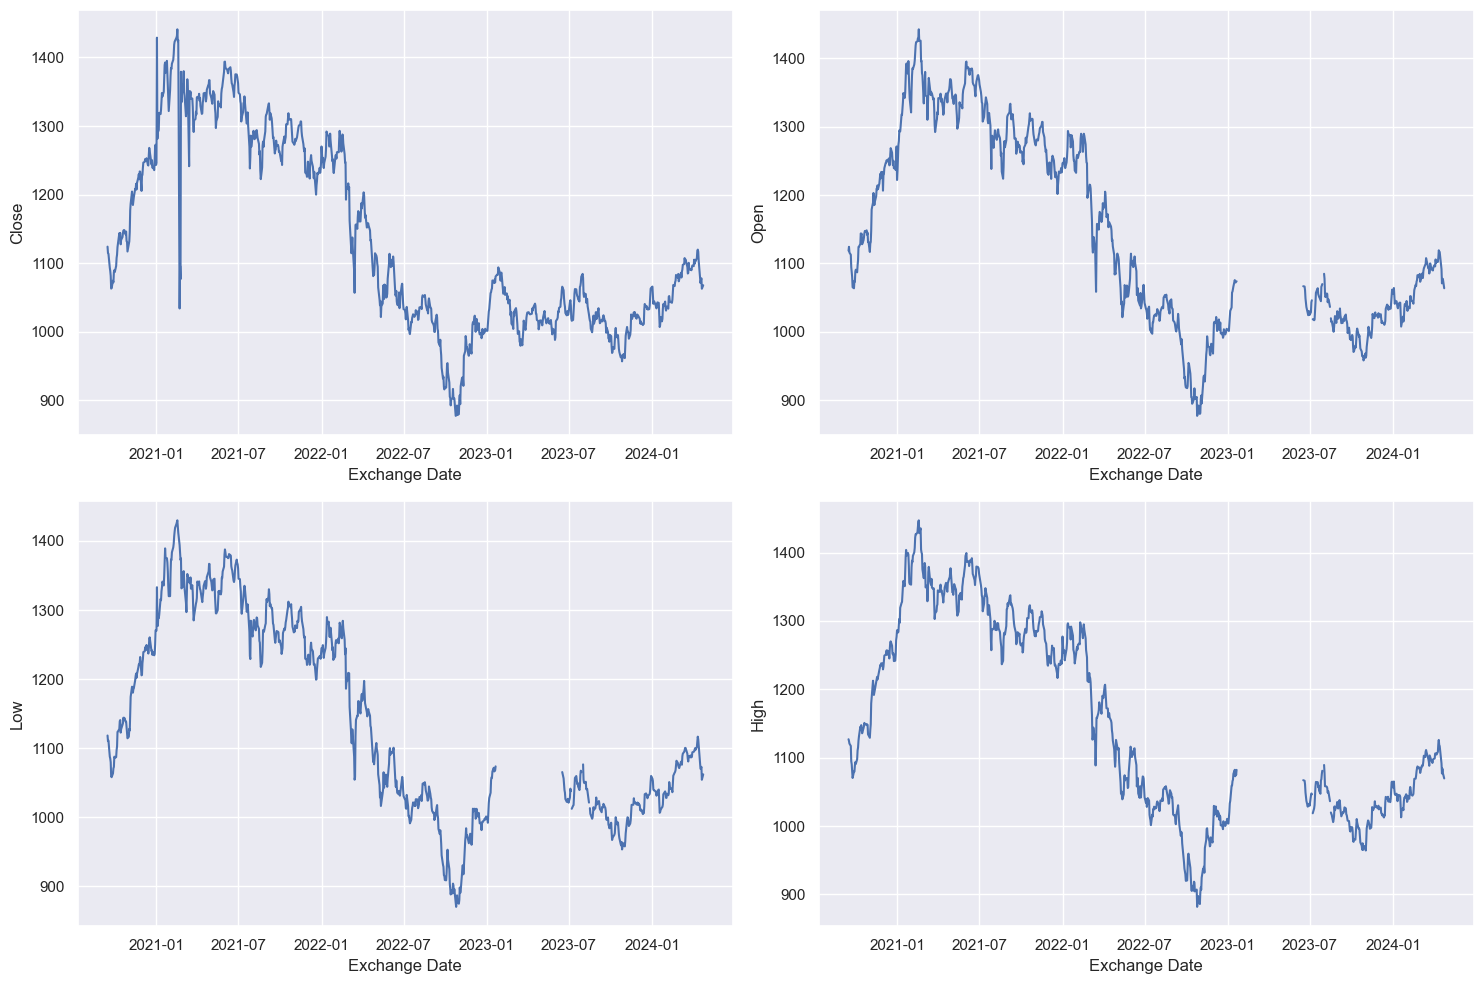

In [10]:
columns_to_plot = ['Close', 'Open', 'Low', 'High']
plt.figure(figsize=(15, 10))
for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(2, 2, i)
    plt.plot(df['Exchange Date'], df[column])
    plt.xlabel('Exchange Date')
    plt.ylabel(column)  
plt.tight_layout()  
plt.show()

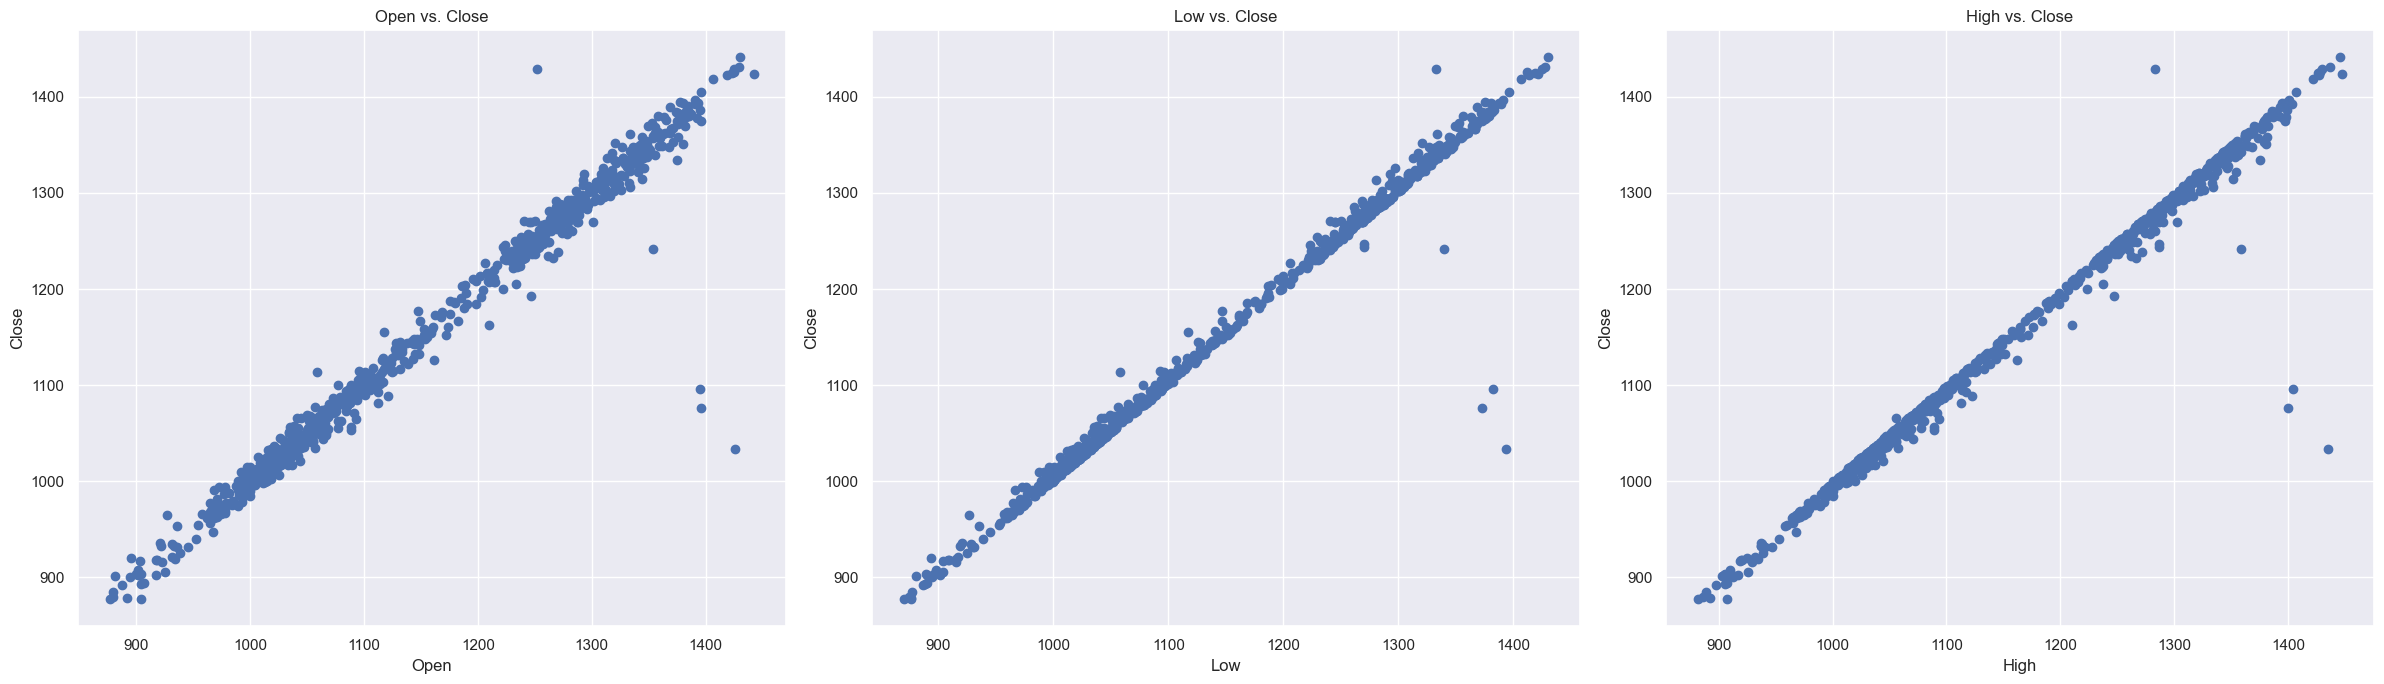

In [11]:
columns_to_plot = ['Open', 'Low', 'High']

# Create a figure and subplots using a for loop
fig, axes = plt.subplots(1, len(columns_to_plot), figsize=(24, 7))

for col, ax in zip(columns_to_plot, axes):
    ax.scatter(df[col], df['Close'])
    ax.set_xlabel(col)
    ax.set_ylabel('Close')
    ax.set_title(f'{col} vs. Close')

plt.tight_layout()
plt.show()

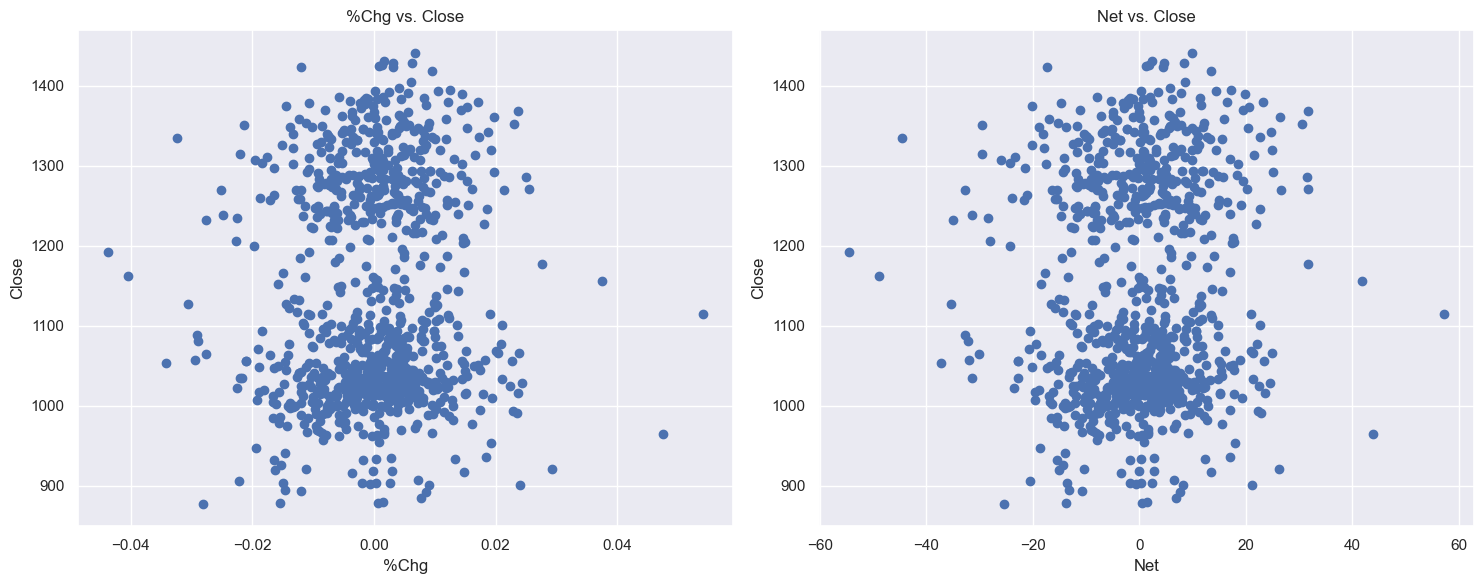

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
ax1.scatter(df['%Chg'], df['Close'])
ax1.set_xlabel('%Chg')
ax1.set_ylabel('Close')
ax1.set_title('%Chg vs. Close') 

ax2.scatter(df['Net'], df['Close'])
ax2.set_xlabel('Net')
ax2.set_ylabel('Close')
ax2.set_title('Net vs. Close') 

plt.tight_layout()
plt.show()

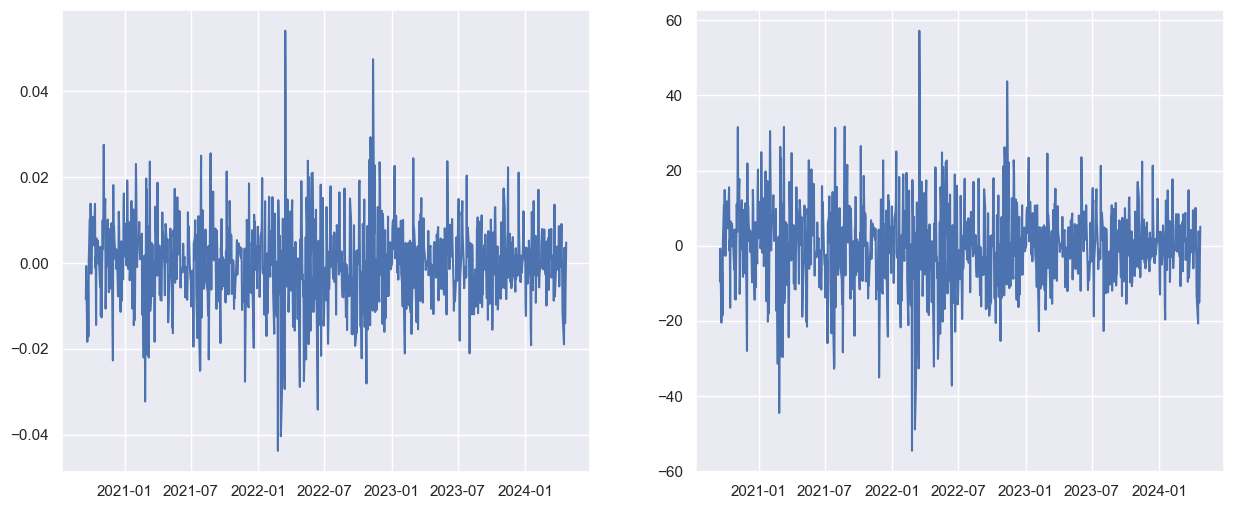

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
ax1.plot(df['Exchange Date'], df['%Chg'])
ax2.plot(df['Exchange Date'], df['Net'])
plt.show()

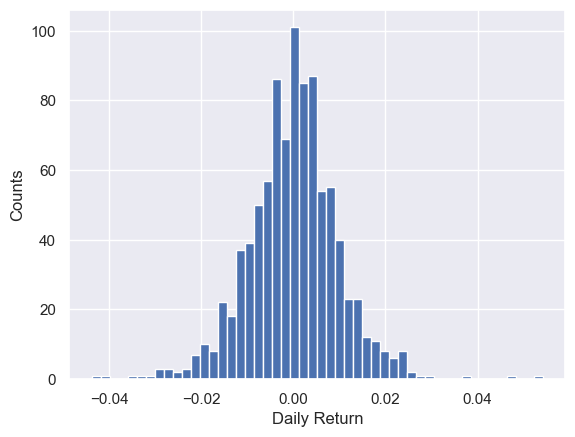

In [14]:
plt.hist(df['%Chg'], bins=50)
plt.xlabel('Daily Return')
plt.ylabel('Counts')
plt.show()

## Outliers

Visualizing the outliers:

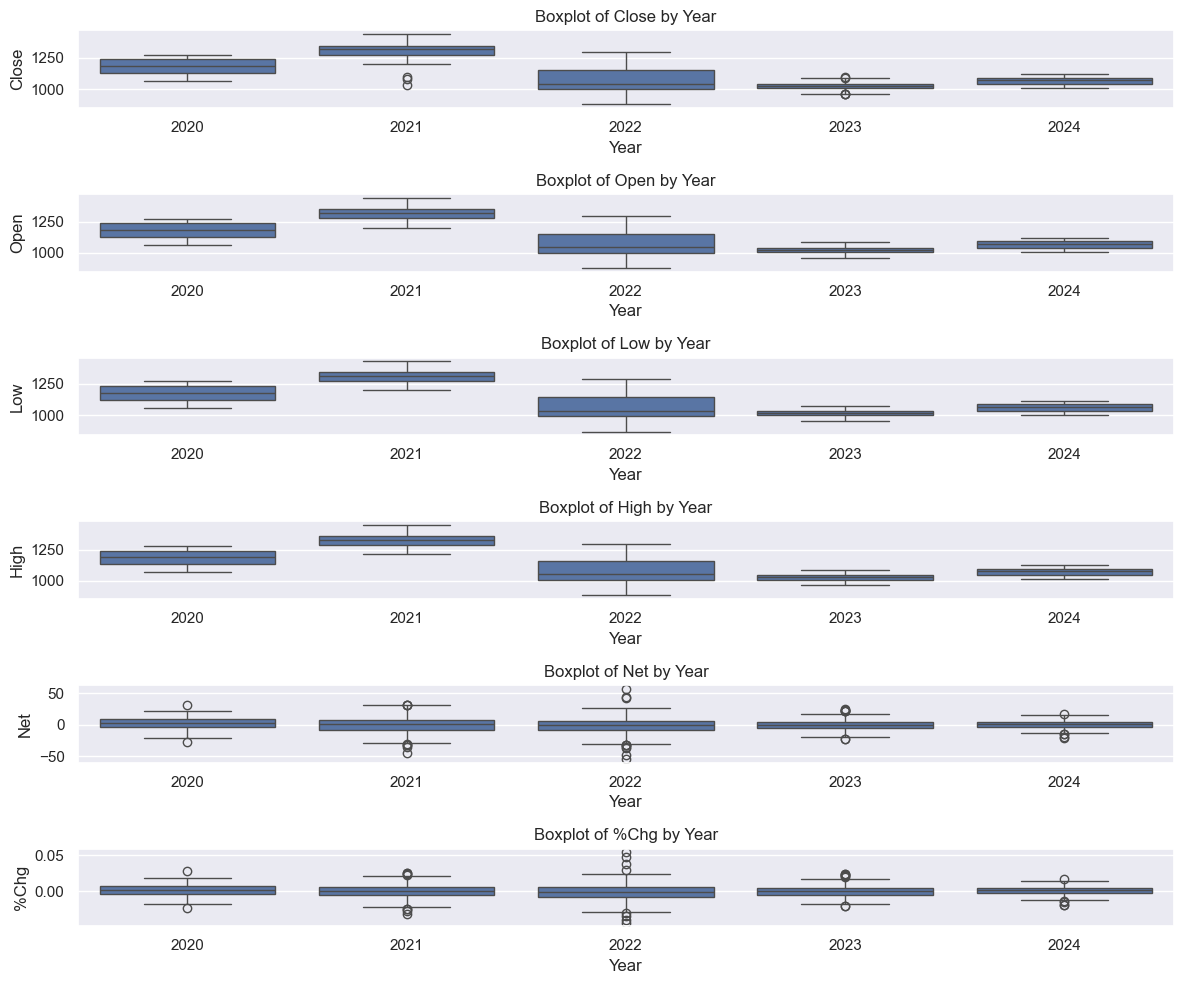

In [15]:
df['Year'] = df['Exchange Date'].dt.year
years = df['Year'].unique()
columns_to_plot = ['Close', 'Open', 'Low', 'High', 'Net', '%Chg']

fig, axes = plt.subplots(nrows=len(columns_to_plot), ncols=1, figsize=(12, 10))

for i, column in enumerate(columns_to_plot):
    ax = axes[i]
    ax.set_title(f"Boxplot of {column} by Year")
    sns.boxplot(x="Year", y=column, data=df, ax=ax)

plt.tight_layout()
plt.show()

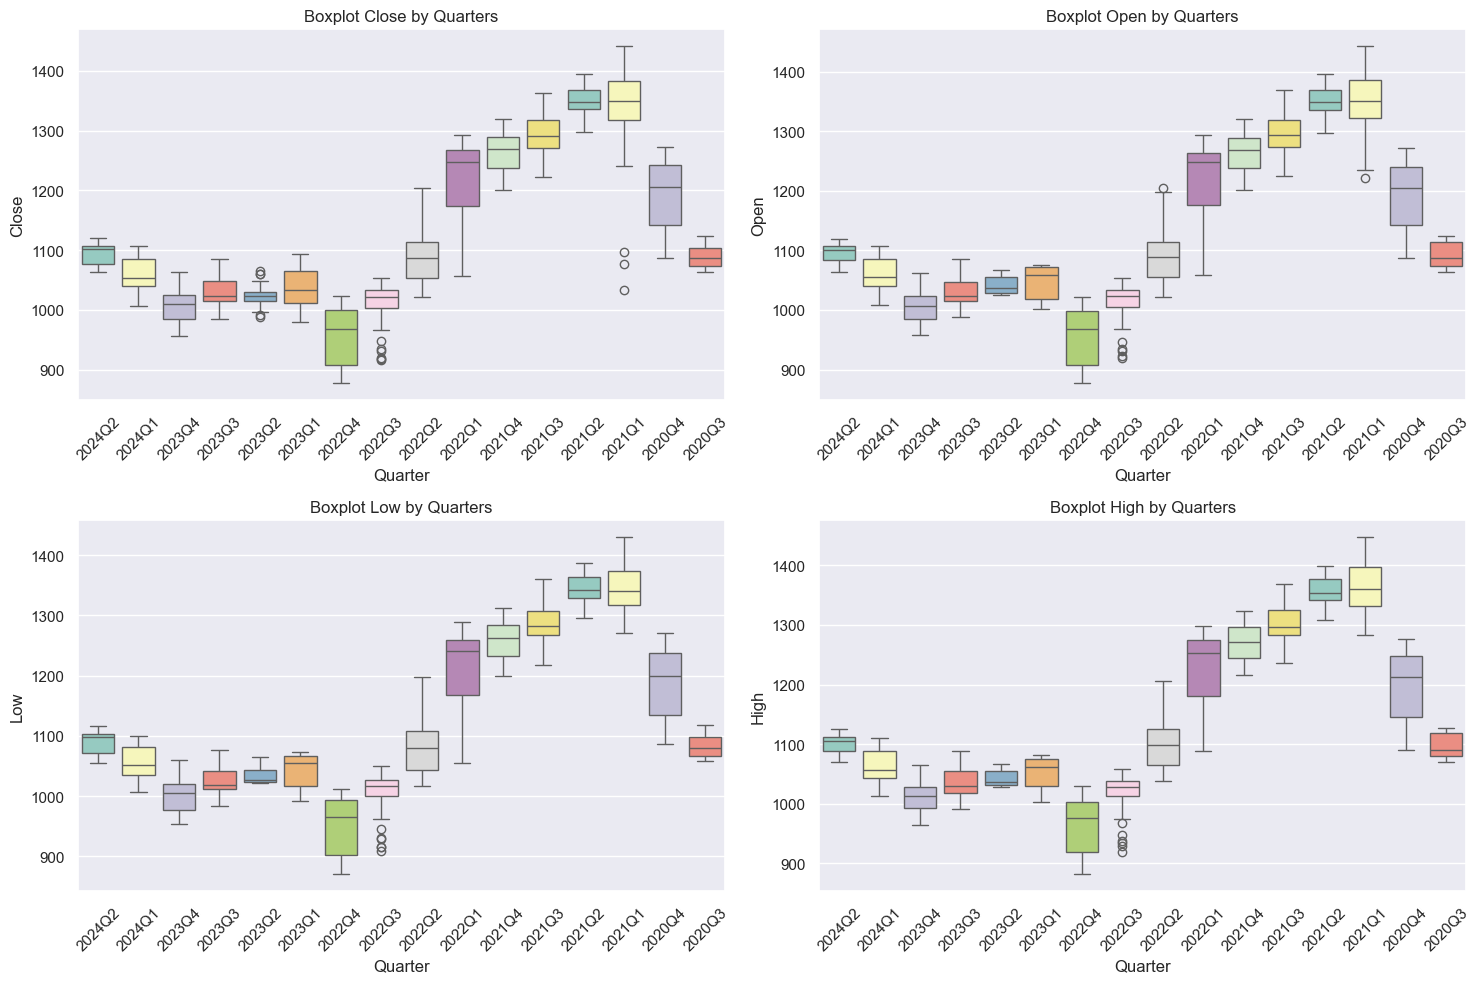

In [16]:
df['Quarter'] = df['Exchange Date'].dt.to_period('Q')
columns_to_plot = ['Close', 'Open', 'Low', 'High']
plt.figure(figsize=(15, 10))

for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x='Quarter', y=column, data=df, palette='Set3', hue = 'Quarter')
    plt.title(f'Boxplot {column} by Quarters')
    plt.xlabel('Quarter')
    plt.ylabel(column)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## Corelation matrix

In [17]:
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(10,5))
sns.heatmap(corr, cmap="Blues", annot=True, mask = mask)
corr

TypeError: float() argument must be a string or a real number, not 'Period'

# Missing Values

In [18]:
# linear interpolation
df_linear_interpolation = df.copy(deep=True)
df_linear_interpolation['Open'] = df_linear_interpolation['Open'].interpolate(method='linear')

# polynomail interpolation
df_polynomial_interpolation = df.copy(deep=True)
df_polynomial_interpolation['Open'] = df_polynomial_interpolation['Open'].interpolate(method='polynomial', order=2)

# pad interpolation
df_pad_interpolation = df.copy(deep=True)
df_pad_interpolation['Open'] = df_pad_interpolation['Open'].ffill()

## Cubic Spline

<div style="color: #ff365e; font-weight: bold;">
    WARNING
</div>

Din nu stiu ce cauza, la cubic spline daca nu rulezi si graficele plotate de Ana mai inainte, mereu o sa aiba anomalia aia unde se strica varful de la 2023-07 cu 1100

In [20]:
from scipy.interpolate import CubicSpline
df_cublicSpline = df.copy(deep=True)

# Extracting non-missing values
x = df['Exchange Date'][df['Open'].notnull()][::-1]
y = df['Open'].dropna()[::-1]

# Perform cubic spline interpolation
cs = CubicSpline(x, y)
interpolated_values = cs(df['Exchange Date'])
# indices of missing values that were filled 
filled_indices = df['Open'].isnull()

# noise function to add on top of interpolation
noise_level = 5
noise = np.random.normal(scale=noise_level, size=len(df_cublicSpline['Open']))
# convoluting with a gaussian distribution to smooth out the noise
smooth_noise = np.convolve(noise, np.ones(20)/2, mode='same')

# adding the noise to the interpolation
interpolated_values[filled_indices] += smooth_noise[filled_indices]

df_cublicSpline['Open'] = interpolated_values

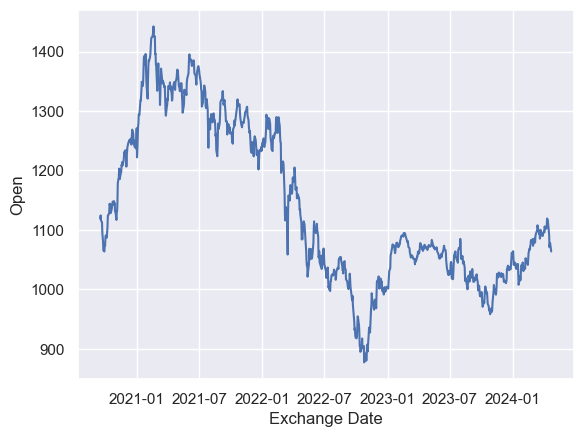

In [21]:
plt.plot(df_cublicSpline['Exchange Date'], df_cublicSpline['Open'])
plt.xlabel('Exchange Date')
plt.ylabel('Open')
plt.show()

## All Interpolations

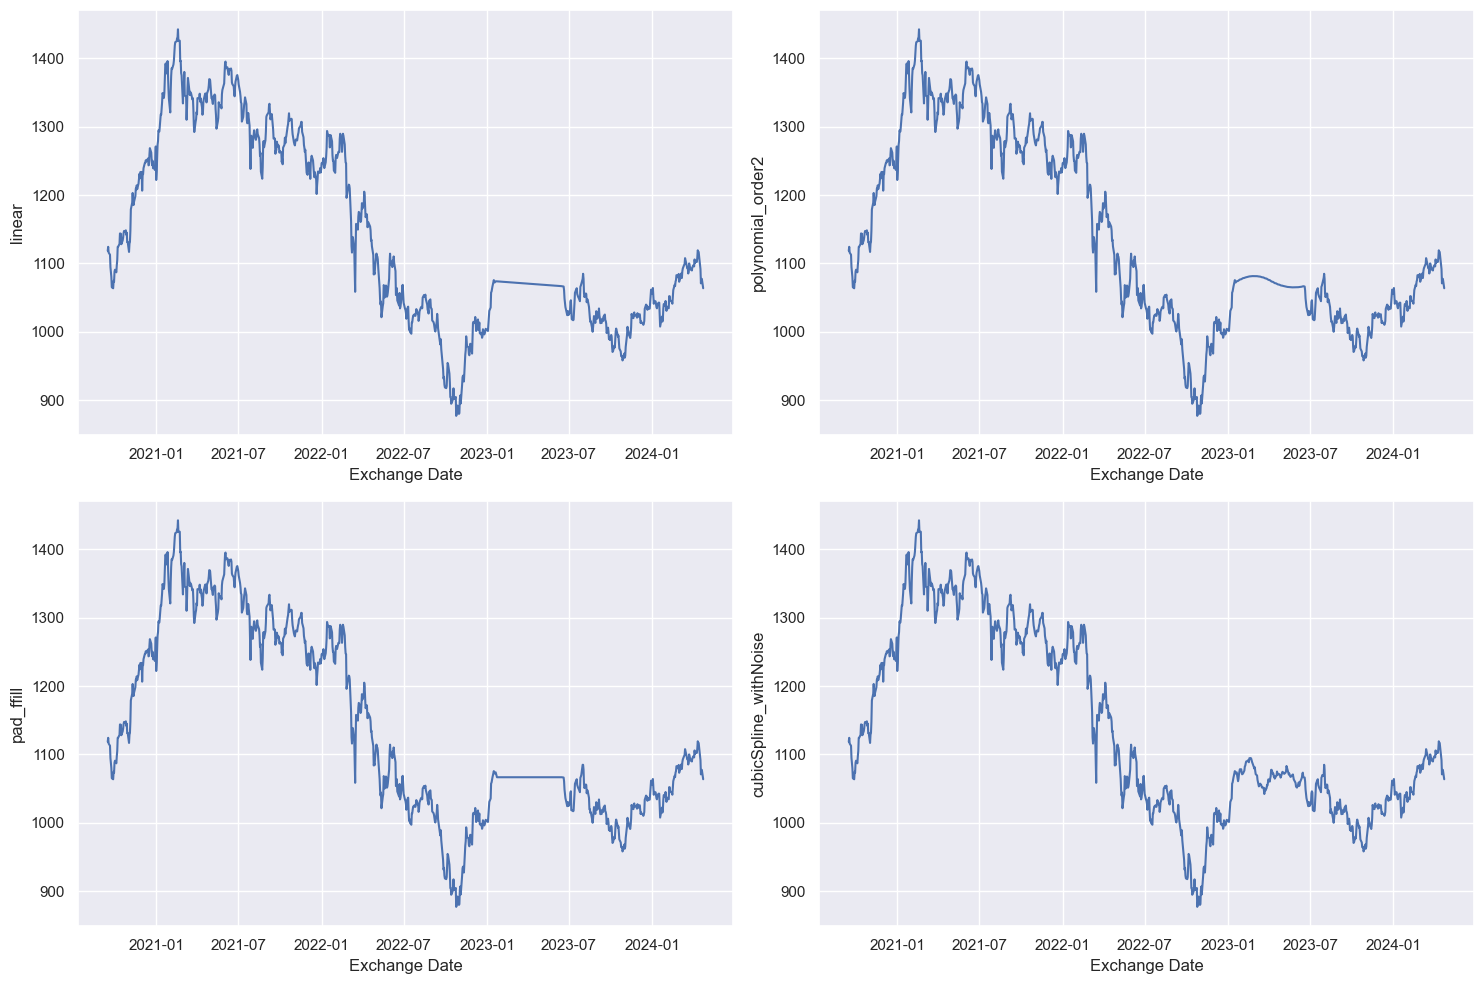

In [22]:
df_interpolations = df.copy(deep=True)

interpolations = [
    ("linear", df_linear_interpolation['Open'].interpolate(method='linear')),
    ("polynomial_order2", df_polynomial_interpolation['Open'].interpolate(method='polynomial', order=2)),
    ("pad_ffill", df_pad_interpolation['Open'].ffill()),
    ("cubicSpline_withNoise", df_cublicSpline['Open'])
]

plt.figure(figsize=(15, 10))
for i, interpolation in enumerate(interpolations, 1):
    plt.subplot(2, 2, i)
    df_interpolations[interpolation[0]] = interpolation[1]
    plt.plot(df_interpolations['Exchange Date'], df_interpolations[interpolation[0]])
    plt.xlabel('Exchange Date')
    plt.ylabel(interpolation[0])
plt.tight_layout()
plt.show()

# Checking NET values 

In [23]:
errors = []
for i in range(1, len(df)):
    if df.iloc[i-1]['Close'] - df.iloc[i-1]['Net'] != df.iloc[i]['Close']:
        errors.append((df.iloc[i-1], df.iloc[i]))
        
print(f"Numar errori la NET: {len(errors)}")
for error in errors:
    print(*error, sep="\n", end="\n\n")

Numar errori la NET: 17
Exchange Date    2024-04-16 00:00:00
Close                        1071.06
Net                           -20.72
%Chg                       -0.018978
Open                          1091.6
Low                          1070.13
High                         1091.64
Year                            2024
Quarter                       2024Q2
Name: 4, dtype: object
Exchange Date    2024-04-12 00:00:00
Close                        1103.61
Net                           -13.09
%Chg                       -0.011722
Open                         1116.74
Low                          1103.61
High                         1117.06
Year                            2024
Quarter                       2024Q2
Name: 5, dtype: object

Exchange Date    2024-03-18 00:00:00
Close                        1094.58
Net                             1.85
%Chg                        0.001693
Open                         1092.81
Low                          1091.85
High                         1097.84
Year

### Duplicate value with different date

<div style="color: #9538ff; font-weight: bold;">
    IMPORTANT
</div>


In [24]:
print(df[df['Exchange Date'] == '2023-01-02'])
print(df[df['Exchange Date'] == '2023-01-01'])

    Exchange Date    Close  Net    %Chg     Open      Low     High  Year  \
339    2023-01-02  1001.45 -0.2 -0.0002  1002.88  1000.17  1003.67  2023   

    Quarter  
339  2023Q1  
    Exchange Date    Close  Net    %Chg     Open      Low     High  Year  \
340    2023-01-01  1001.45 -0.2 -0.0002  1002.88  1000.17  1003.67  2023   

    Quarter  
340  2023Q1  


# Matrix for Differences

In [25]:
columns = ["Exchange Date", "Close", "Net", "%Chg", "Open", "Low", "High"]
difference_matrix = []

for i in range(len(df)):
    try:
        row1 = df.loc[i, columns].values
        row2_diff = (df.loc[:, columns] == row1).sum(axis=1)
        difference_matrix.append(row2_diff)
    except:
        difference_matrix.append(0)
        
print(difference_matrix)

[0      7
1      0
2      0
3      0
4      0
      ..
937    0
938    0
939    0
940    0
941    0
Length: 940, dtype: int64, 0      0
1      7
2      0
3      0
4      0
      ..
937    0
938    0
939    0
940    0
941    0
Length: 940, dtype: int64, 0      0
1      0
2      7
3      0
4      0
      ..
937    0
938    0
939    0
940    0
941    0
Length: 940, dtype: int64, 0      0
1      0
2      0
3      7
4      0
      ..
937    0
938    0
939    0
940    0
941    0
Length: 940, dtype: int64, 0      0
1      0
2      0
3      0
4      7
      ..
937    0
938    0
939    0
940    0
941    0
Length: 940, dtype: int64, 0      0
1      0
2      0
3      0
4      0
      ..
937    0
938    0
939    0
940    0
941    0
Length: 940, dtype: int64, 0      0
1      0
2      0
3      0
4      0
      ..
937    0
938    0
939    0
940    0
941    0
Length: 940, dtype: int64, 0      0
1      0
2      0
3      0
4      0
      ..
937    0
938    0
939    0
940    0
941    0
Length: 940, dtype

In [26]:
indices_of_common_rows = []

for i, row in enumerate(difference_matrix):
    if i in [34, 35, 94, 93]:
        continue

    for j in range(len(row)):
        if j in [34, 35, 94, 93]:
            continue

        if i != j and row[j] != 0:
            indices_of_common_rows.append((i, j, row[j]))

print(indices_of_common_rows)

[(1, 187, 1), (4, 17, 1), (9, 55, 1), (10, 196, 1), (12, 105, 1), (13, 513, 1), (14, 28, 1), (15, 108, 1), (17, 4, 1), (28, 14, 1), (36, 326, 1), (46, 307, 1), (46, 635, 1), (49, 735, 1), (51, 934, 1), (53, 435, 1), (53, 646, 1), (54, 70, 1), (54, 95, 1), (55, 9, 1), (59, 480, 1), (62, 166, 1), (62, 170, 1), (70, 54, 1), (70, 481, 1), (72, 299, 1), (73, 186, 1), (75, 658, 1), (85, 685, 1), (86, 335, 1), (88, 512, 1), (89, 202, 1), (91, 434, 1), (95, 54, 1), (96, 300, 1), (97, 418, 1), (100, 165, 1), (100, 457, 1), (101, 644, 1), (103, 449, 1), (105, 12, 1), (105, 106, 3), (106, 105, 3), (108, 15, 1), (115, 154, 1), (127, 376, 1), (132, 303, 1), (135, 417, 1), (154, 115, 1), (154, 259, 1), (155, 228, 1), (156, 759, 1), (165, 100, 1), (166, 62, 1), (168, 767, 1), (170, 62, 1), (181, 523, 1), (181, 869, 1), (186, 73, 1), (187, 1, 1), (195, 240, 1), (196, 10, 1), (202, 89, 1), (204, 427, 1), (211, 874, 1), (212, 329, 1), (212, 590, 1), (212, 742, 1), (221, 347, 1), (227, 450, 1), (228, 155

In [27]:
filtered_indices = [ind for ind in indices_of_common_rows if ind[2] != 1]
print(filtered_indices)

[(105, 106, 3), (106, 105, 3), (339, 340, 6), (340, 339, 6), (863, 864, 2), (864, 863, 2)]


### In data_csv_file.csv

107,108 - 3 common values 
341,342 - 6 common values
865,866 - 2 common values

# Checking %CHG values

In [28]:
chg_errors = []
epsilon = 0.015

for i in range(1, len(df)):
    percentage = (df.iloc[i-1]['Close'] - df.iloc[i]['Close']) / df.iloc[i-1]['Close']
    
    if not (df.iloc[i - 1]['%Chg'] - epsilon <= percentage <= df.iloc[i - 1]['%Chg'] + epsilon):
        chg_errors.append((df.iloc[i-1], df.iloc[i]))

print(f"Numar errori la %CHG: {len(chg_errors)}")
for error in chg_errors:
    print(*error, sep="\n", end="\n\n")

Numar errori la %CHG: 10
Exchange Date    2022-01-03 00:00:00
Close                        1248.84
Net                             1.84
%Chg                        0.001476
Open                         1246.76
Low                          1244.45
High                         1253.12
Year                            2022
Quarter                       2022Q1
Name: 600, dtype: object
Exchange Date    2022-01-01 00:00:00
Close                        1270.15
Net                             1.83
%Chg                          0.0016
Open                          1246.5
Low                          1244.77
High                         1277.12
Year                            2022
Quarter                       2022Q1
Name: 601, dtype: object

Exchange Date    2022-01-01 00:00:00
Close                        1270.15
Net                             1.83
%Chg                          0.0016
Open                          1246.5
Low                          1244.77
High                         1277.12